In [2]:
import os
import time
import pandas as pd
from datetime import datetime, timedelta
from pycoingecko import CoinGeckoAPI
from tqdm import tqdm

# === Step 1: Load top tokens ===
volume_df = pd.read_csv("volume_90d.csv")  # <- Make sure this is by 365d volume!
top_tokens = volume_df["Token"].str.lower().tolist()

# === Step 2: Setup output directory ===
output_dir = "daily_prices_top100_365d"
os.makedirs(output_dir, exist_ok=True)

# === Step 3: Initialize CoinGecko API ===
cg = CoinGeckoAPI()

# === Step 4: Download historical daily prices ===
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

def fetch_daily_prices(token_id):
    try:
        data = cg.get_coin_market_chart_range_by_id(
            id=token_id,
            vs_currency="usd",
            from_timestamp=int(start_date.timestamp()),
            to_timestamp=int(end_date.timestamp())
        )
        prices = data["prices"]
        df = pd.DataFrame(prices, columns=["timestamp", "price"])
        df["date"] = pd.to_datetime(df["timestamp"], unit='ms')
        df = df[["date", "price"]].set_index("date").resample("1D").mean()
        return df
    except Exception as e:
        print(f"❌ {token_id}: {e}")
        return None

print(f"📦 Saving daily price data for 365d to → {output_dir}")

for token in tqdm(top_tokens, desc="⏬ Downloading"):
    filename = os.path.join(output_dir, f"{token}.csv")
    if os.path.exists(filename):
        continue
    df = fetch_daily_prices(token)
    if df is not None and not df.empty:
        df.to_csv(filename)
    time.sleep(1.2)  # Respect CoinGecko's rate limits!

print("✅ Done. All available token prices saved.")


📦 Saving daily price data for 365d to → daily_prices_top100_365d


⏬ Downloading: 100%|██████████| 100/100 [26:27<00:00, 15.87s/it]

✅ Done. All available token prices saved.


In [3]:
import os
import pandas as pd

folder = "daily_prices_top100_365d"
files = sorted([f for f in os.listdir(folder) if f.endswith('.csv')])

all_prices = []
tokens = []

for fname in files:
    token = fname.replace('.csv','')
    df = pd.read_csv(os.path.join(folder, fname), parse_dates=["date"])
    df = df.set_index("date").rename(columns={"price": token})
    all_prices.append(df)
    tokens.append(token)

# Combine
prices_df = pd.concat(all_prices, axis=1)
prices_df = prices_df.sort_index()
print(f"✅ Combined daily prices shape: {prices_df.shape}")
prices_df.head()


✅ Combined daily prices shape: (365, 100)


,aave,algorand,aptos,arbitrum-bridged-wbtc-arbitrum-one,arbitrum-bridged-weth-arbitrum-one,arbitrum,arweave,avalanche-2,binance-bridged-usdc-bnb-smart-chain,binance-bridged-usdt-bnb-smart-chain,...,virtual-protocol,wbnb,weth,whitebit,worldcoin-wld,wrapped-avax,wrapped-bitcoin,wrapped-eeth,wrapped-hype,wrapped-steth
date,,,,,,,,,,,,,,,,,,,,,
2024-07-26,92.939274,0.137071,6.626602,NaN,NaN,0.698618,29.980977,27.257321,1.000974,1.001690,...,0.047975,572.499036,3176.667467,10.098438,2.116674,27.260168,65696.782099,3314.146315,NaN,3727.029182
2024-07-27,97.856143,0.142730,6.973911,NaN,NaN,0.727691,31.120060,28.691237,0.999400,1.000594,...,0.052041,581.701431,3279.264724,10.102435,2.362659,28.710348,67924.060034,3421.816083,NaN,3849.097472
2024-07-28,101.428231,0.143199,7.141218,NaN,NaN,0.722590,31.403867,28.145258,0.998923,0.999161,...,0.052009,582.440777,3254.165431,10.119587,2.337898,28.105102,68015.493035,3397.713291,NaN,3817.405017
2024-07-29,98.840502,0.139170,6.845982,NaN,NaN,0.713158,30.682455,27.406340,1.001273,1.001547,...,0.052228,584.910955,3272.864437,10.190571,2.348238,27.397774,68161.440978,3414.608049,NaN,3839.460992
2024-07-30,104.876306,0.138930,6.763899,NaN,NaN,0.703482,30.748588,27.130984,0.999416,0.997281,...,0.051766,573.594271,3314.278045,10.173645,2.278636,27.166909,66914.430876,3459.446423,NaN,3891.135551


In [4]:
import numpy as np

# 1. Drop tokens with too much missing data (e.g. >30%)
coverage = prices_df.notna().mean()
tokens_good = coverage[coverage >= 0.7].index
prices_clean = prices_df[tokens_good]

# 2. Fill missing values (first forward, then back for leading NaNs)
prices_filled = prices_clean.ffill().bfill()

# 3. Compute log returns
log_returns = np.log(prices_filled / prices_filled.shift(1)).iloc[1:]
print(f"✅ Log returns shape: {log_returns.shape}")
log_returns.head()


✅ Log returns shape: (364, 90)


,aave,algorand,aptos,arbitrum-bridged-wbtc-arbitrum-one,arbitrum-bridged-weth-arbitrum-one,arbitrum,arweave,avalanche-2,binance-bridged-usdc-bnb-smart-chain,binance-bridged-usdt-bnb-smart-chain,...,usd-coin,virtual-protocol,wbnb,weth,whitebit,worldcoin-wld,wrapped-avax,wrapped-bitcoin,wrapped-eeth,wrapped-steth
date,,,,,,,,,,,,,,,,,,,,,
2024-07-27,0.051552,0.040455,0.051084,0.0,0.0,0.040771,0.037290,0.051270,-0.001574,-0.001095,...,-0.000072,0.081360,0.015946,0.031787,0.000396,0.109942,0.051831,0.033340,0.031971,0.032227
2024-07-28,0.035853,0.003281,0.023707,0.0,0.0,-0.007035,0.009078,-0.019213,-0.000477,-0.001433,...,-0.000422,-0.000614,0.001270,-0.007683,0.001696,-0.010536,-0.021307,0.001345,-0.007069,-0.008268
2024-07-29,-0.025844,-0.028539,-0.042221,0.0,0.0,-0.013139,-0.023240,-0.026604,0.002349,0.002385,...,0.000387,0.004190,0.004232,0.005730,0.006990,0.004413,-0.025489,0.002144,0.004960,0.005761
2024-07-30,0.059274,-0.001732,-0.012062,0.0,0.0,-0.013660,0.002153,-0.010098,-0.001856,-0.004268,...,-0.001236,-0.008880,-0.019537,0.012574,-0.001662,-0.030088,-0.008462,-0.018464,0.013046,0.013369
2024-07-31,0.003781,-0.010343,-0.024977,0.0,0.0,-0.037652,-0.051911,-0.029597,0.001972,0.002813,...,0.001037,-0.092606,0.022074,-0.011341,0.004913,-0.036353,-0.030598,-0.011220,-0.011787,-0.011994


In [6]:
# Load your volume data for the relevant window (should cover 365d, or use 90d as an approximation)
volume_df = pd.read_csv("volume_90d.csv")   # or volume_365d.csv if available
volume_map = volume_df.set_index("Token")["Volume"].to_dict()

# Align volumes with the columns of your log_returns DataFrame
volumes = pd.Series([volume_map.get(t, np.nan) for t in log_returns.columns], index=log_returns.columns)
weights = volumes / volumes.sum()  # normalize

# Compute the daily market index: weighted sum of log returns
market_index = (log_returns * weights).sum(axis=1)
market_index = market_index.to_frame("Market_Index")
print("✅ Market Index built, preview:")
print(market_index)


✅ Market Index built, preview:
            Market_Index
date                    
2024-07-27      0.020028
2024-07-28     -0.002019
2024-07-29     -0.001042
2024-07-30     -0.002332
2024-07-31     -0.005923
...                  ...
2025-07-21      0.017082
2025-07-22      0.006172
2025-07-23      0.004003
2025-07-24     -0.027537
2025-07-25     -0.002658

[364 rows x 1 columns]


In [7]:
import statsmodels.api as sm
from tqdm import tqdm

# Ensure indices align
common_dates = log_returns.index.intersection(market_index.index)
log_returns_aligned = log_returns.loc[common_dates]
market_index_aligned = market_index.loc[common_dates]

# Prepare output DataFrames
residuals = pd.DataFrame(index=common_dates)
capm_summary = []

for token in tqdm(log_returns_aligned.columns, desc="CAPM regression per token"):
    y = log_returns_aligned[token]
    X = sm.add_constant(market_index_aligned["Market_Index"])
    
    if y.isnull().sum() > 20:
        print(f"⚠️ Skipping {token}: too many NaNs")
        continue

    model = sm.OLS(y, X, missing='drop').fit()
    resids = model.resid
    residuals[token] = resids

    capm_summary.append({
        "Token": token,
        "Alpha": model.params['const'],
        "Beta": model.params['Market_Index'],
        "R2": model.rsquared,
        "Residual_Std": resids.std()
    })

capm_summary = pd.DataFrame(capm_summary)
print("✅ Residuals shape:", residuals.shape)
print("✅ CAPM summary:\n", capm_summary.head())


CAPM regression per token: 100%|██████████| 90/90 [00:00<00:00, 427.26it/s]

✅ Residuals shape: (364, 90)
✅ CAPM summary:
                                 Token     Alpha      Beta        R2  \
0                                aave  0.001673  2.286529  0.545029   
1                            algorand  0.000283  2.403114  0.589594   
2                               aptos -0.002325  2.151196  0.590413   
3  arbitrum-bridged-wbtc-arbitrum-one  0.001201  1.209670  0.793650   
4  arbitrum-bridged-weth-arbitrum-one -0.000131  1.827660  0.797193   

   Residual_Std  
0      0.037598  
1      0.036083  
2      0.032246  
3      0.011101  
4      0.016590  


In [8]:
from scipy.stats import spearmanr

# Compute Spearman correlation matrix
corr_matrix, _ = spearmanr(residuals.fillna(0), axis=0)
# Convert to distance matrix
dist_matrix = 1 - corr_matrix
dist_df = pd.DataFrame(dist_matrix, index=residuals.columns, columns=residuals.columns)
print("✅ Spearman distance matrix shape:", dist_df.shape)


✅ Spearman distance matrix shape: (90, 90)


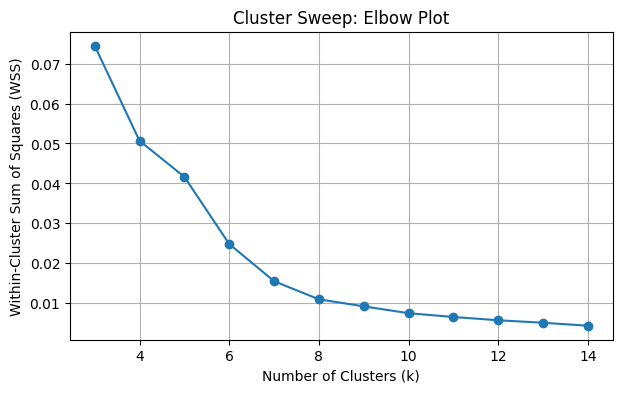

In [11]:
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
import numpy as np

# MDS: Project tokens to 2D space for clustering/visuals
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
coords = mds.fit_transform(dist_df)

# Get volume weights
vol_df = pd.read_csv("volume_90d.csv", index_col="Token")
volumes = vol_df.loc[residuals.columns]["Volume"].values
weights = volumes / volumes.sum()

# KMeans sweep
inertia = []
labels_dict = {}
for k in range(3, 15):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(coords, sample_weight=weights)
    inertia.append(km.inertia_)
    labels_dict[k] = labels

# Plot WSS (inertia) for each k
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(range(3,15), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.title('Cluster Sweep: Elbow Plot')
plt.grid(True)
plt.show()


In [12]:
best_k = 7
token_labels = labels_dict[best_k]  # from previous sweep
cluster_map = pd.Series(token_labels, index=residuals.columns, name="Cluster")
# Optional: Attach to summary
capm_summary["Cluster"] = cluster_map.values


In [13]:
for c in range(best_k):
    print(f"\nCluster {c+1}:")
    print(capm_summary.loc[capm_summary["Cluster"]==c, "Token"].tolist())



Cluster 1:
['aave', 'arbitrum-bridged-weth-arbitrum-one', 'ethereum', 'l2-standard-bridged-weth-base', 'mantle', 'staked-ether', 'wbnb', 'weth', 'wrapped-eeth', 'wrapped-steth']

Cluster 2:
['binance-bridged-usdc-bnb-smart-chain', 'binance-bridged-usdt-bnb-smart-chain', 'bitcoin-cash', 'bitget-token', 'bittensor', 'dai', 'ethena-usde', 'first-digital-usd', 'litecoin', 'spx6900', 'tether', 'tron', 'usd-coin']

Cluster 3:
['algorand', 'avalanche-2', 'cardano', 'cosmos', 'fetch-ai', 'floki', 'gala', 'injective-protocol', 'internet-computer', 'jasmycoin', 'near', 'polkadot', 'pyth-network', 'sei-network', 'shiba-inu', 'tezos', 'the-sandbox', 'worldcoin-wld', 'wrapped-avax']

Cluster 4:
['fartcoin', 'kaspa', 'mantra-dao', 'ondo-finance', 'raydium', 'ripple', 'solana', 'stellar', 'sui', 'thorchain', 'virtual-protocol']

Cluster 5:
['aptos', 'arbitrum', 'arweave', 'binancecoin', 'celestia', 'chainlink', 'compound-governance-token', 'conflux-token', 'curve-dao-token', 'eigenlayer', 'ethena', 

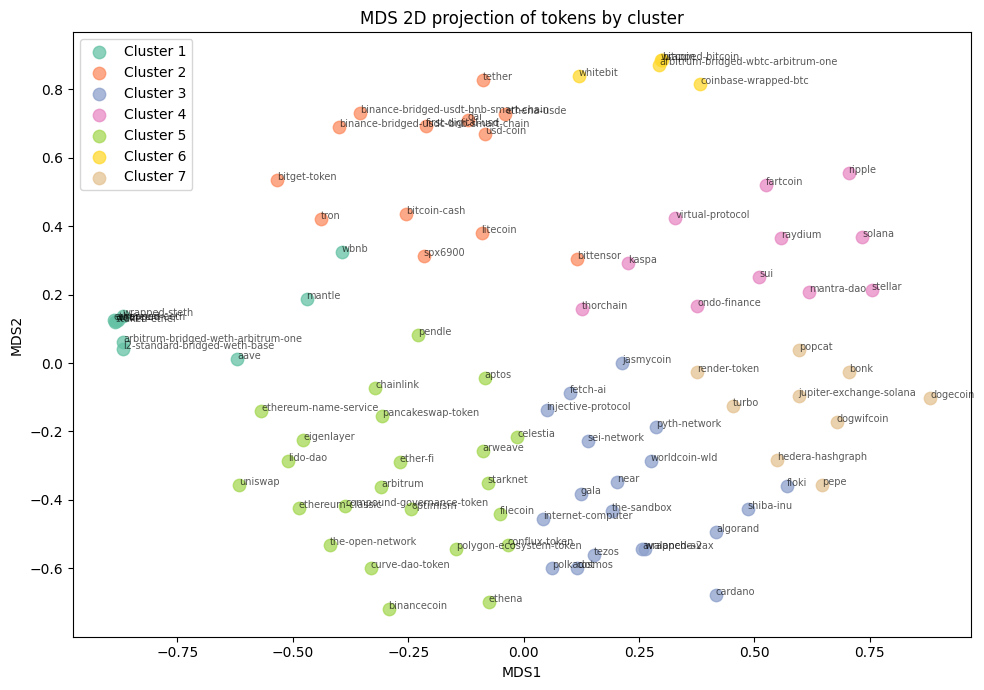

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette("Set2", best_k)

plt.figure(figsize=(10,7))
for c in range(best_k):
    idx = cluster_map == c
    plt.scatter(coords[idx,0], coords[idx,1], label=f'Cluster {c+1}', s=80, alpha=0.75, color=palette[c])
for i, token in enumerate(residuals.columns):
    plt.text(coords[i,0], coords[i,1], token, fontsize=7, alpha=0.65)
plt.title("MDS 2D projection of tokens by cluster")
plt.xlabel("MDS1"); plt.ylabel("MDS2")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\siddh\AppData\Local\Temp\ipykernel_36648\3566692825.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=capm_summary, x="Cluster", y=metric, palette="Set2", showfliers=False)


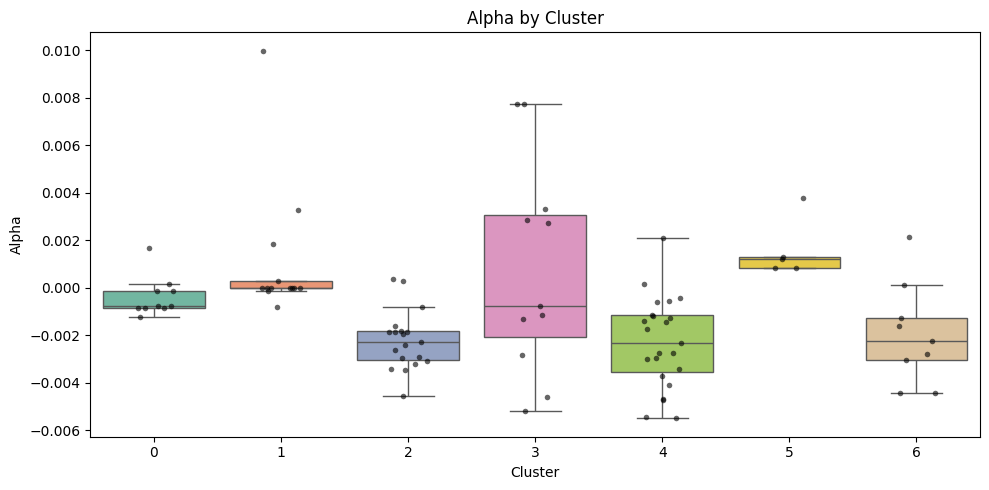

C:\Users\siddh\AppData\Local\Temp\ipykernel_36648\3566692825.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=capm_summary, x="Cluster", y=metric, palette="Set2", showfliers=False)


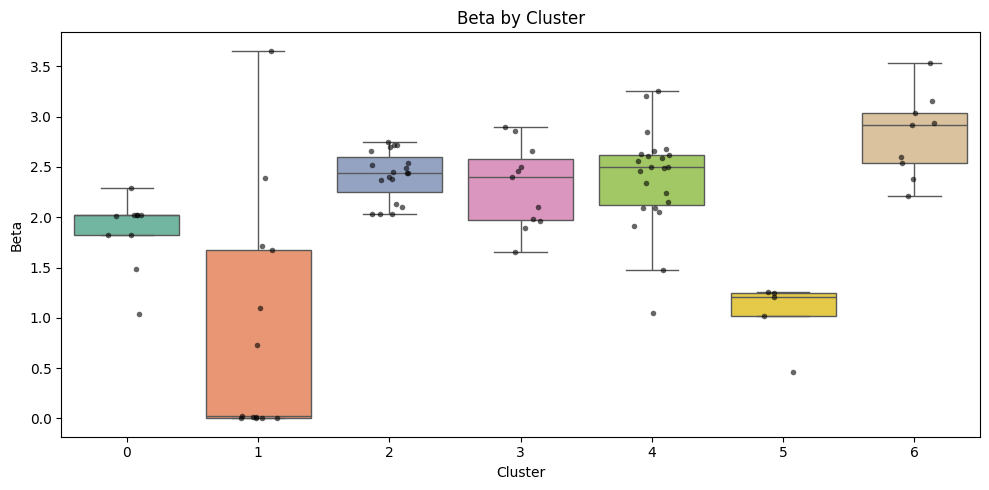

C:\Users\siddh\AppData\Local\Temp\ipykernel_36648\3566692825.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=capm_summary, x="Cluster", y=metric, palette="Set2", showfliers=False)


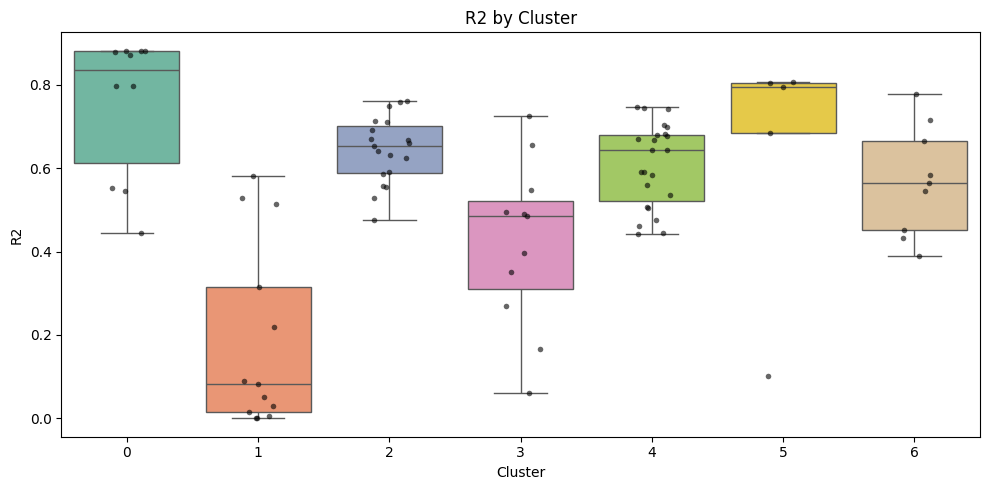

C:\Users\siddh\AppData\Local\Temp\ipykernel_36648\3566692825.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=capm_summary, x="Cluster", y=metric, palette="Set2", showfliers=False)


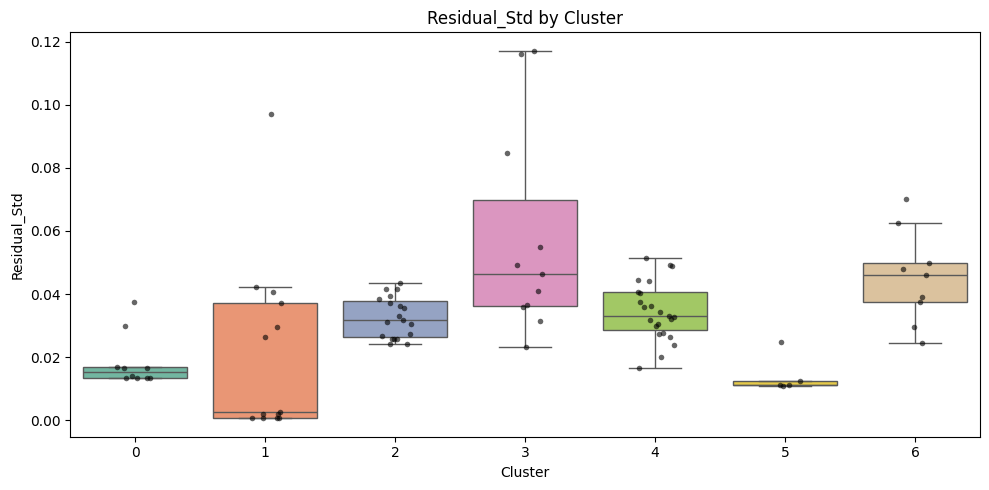

In [15]:
metrics = ["Alpha", "Beta", "R2", "Residual_Std"]

for metric in metrics:
    plt.figure(figsize=(10,5))
    sns.boxplot(data=capm_summary, x="Cluster", y=metric, palette="Set2", showfliers=False)
    sns.stripplot(data=capm_summary, x="Cluster", y=metric, color="k", size=4, alpha=0.6, jitter=0.15)
    plt.title(f'{metric} by Cluster')
    plt.tight_layout()
    plt.show()


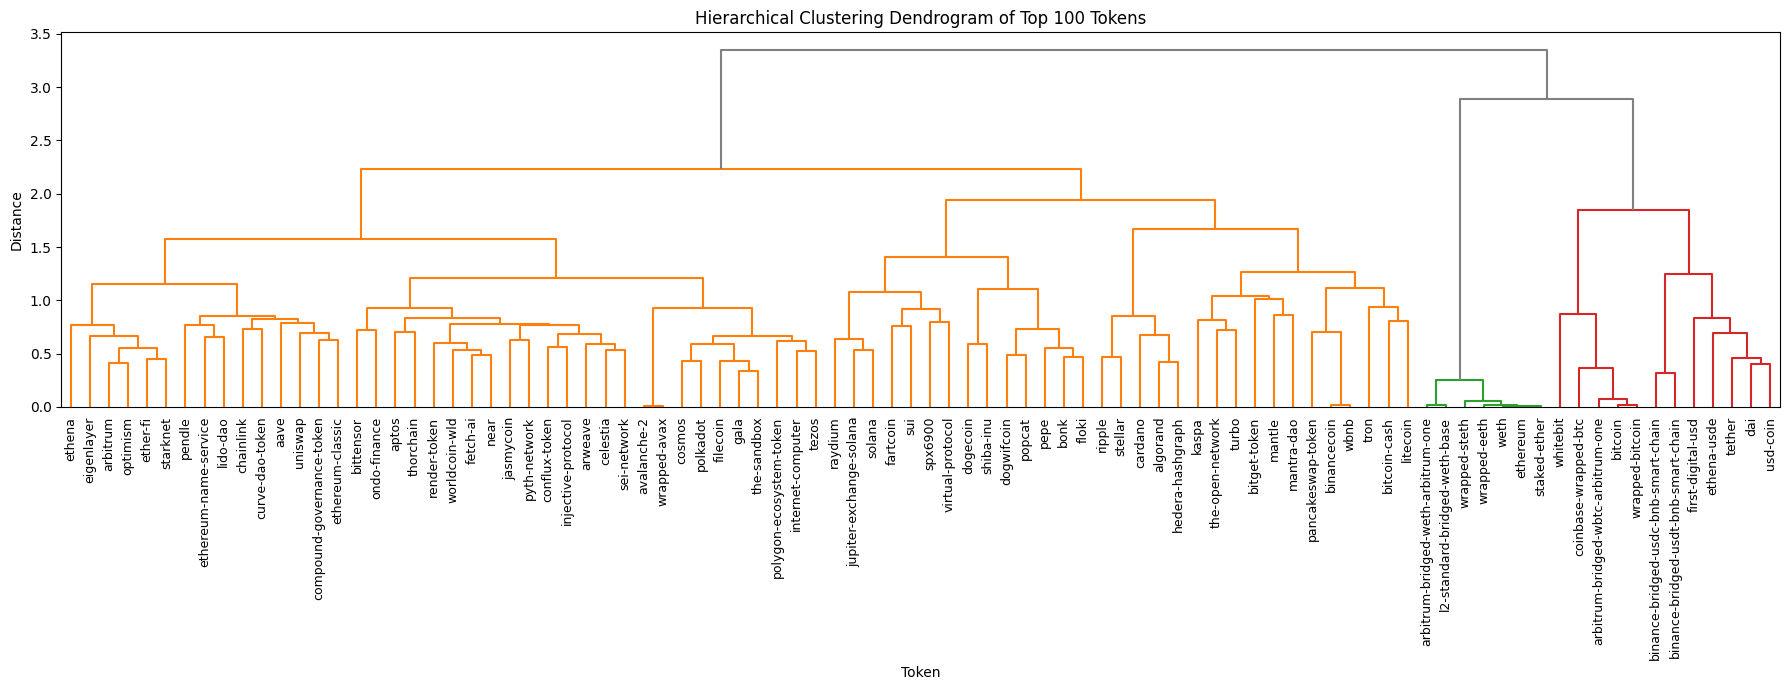

In [17]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# If dist_matrix is a numpy array, use it directly:
condensed_dist = squareform(dist_matrix, checks=False)

Z = linkage(condensed_dist, method='ward')

plt.figure(figsize=(18, 7))
dendrogram(
    Z,
    labels=residuals.columns,  # Or your token names list
    leaf_rotation=90,
    leaf_font_size=9,
    color_threshold=None,
    above_threshold_color='grey'
)
plt.title("Hierarchical Clustering Dendrogram of Top 100 Tokens")
plt.xlabel("Token")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


In [24]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 7
clustering = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='precomputed',      # replaces affinity
    linkage='average'
)
clusters = clustering.fit_predict(dist_matrix)


IndexError: index 90 is out of bounds for axis 0 with size 90

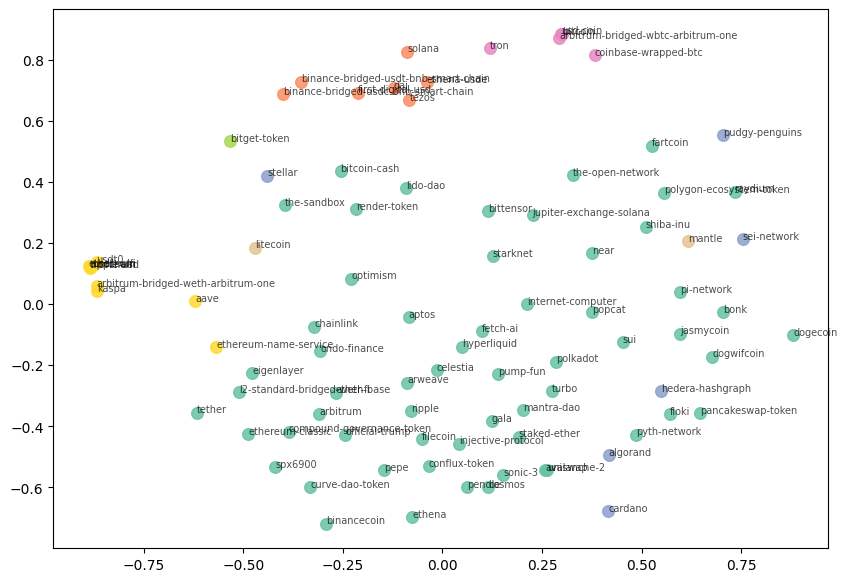

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
coords = mds.fit_transform(dist_matrix)

palette = sns.color_palette('Set2', n_colors=n_clusters)
plt.figure(figsize=(10,7))
for i in range(n_clusters):
    idx = clusters == i
    plt.scatter(coords[idx, 0], coords[idx, 1], s=70, label=f'Cluster {i+1}', alpha=0.85, color=palette[i])
for i, token in enumerate(tokens):
    plt.text(coords[i,0], coords[i,1], token, fontsize=7, alpha=0.7)
plt.legend()
plt.title("MDS 2D Projection of Tokens by Cluster")
plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.tight_layout()
plt.show()


In [27]:
tokens = list(dist_matrix.index) if hasattr(dist_matrix, "index") else list(range(dist_matrix.shape[0]))
print(len(tokens), dist_matrix.shape[0])  # Should be equal


90 90


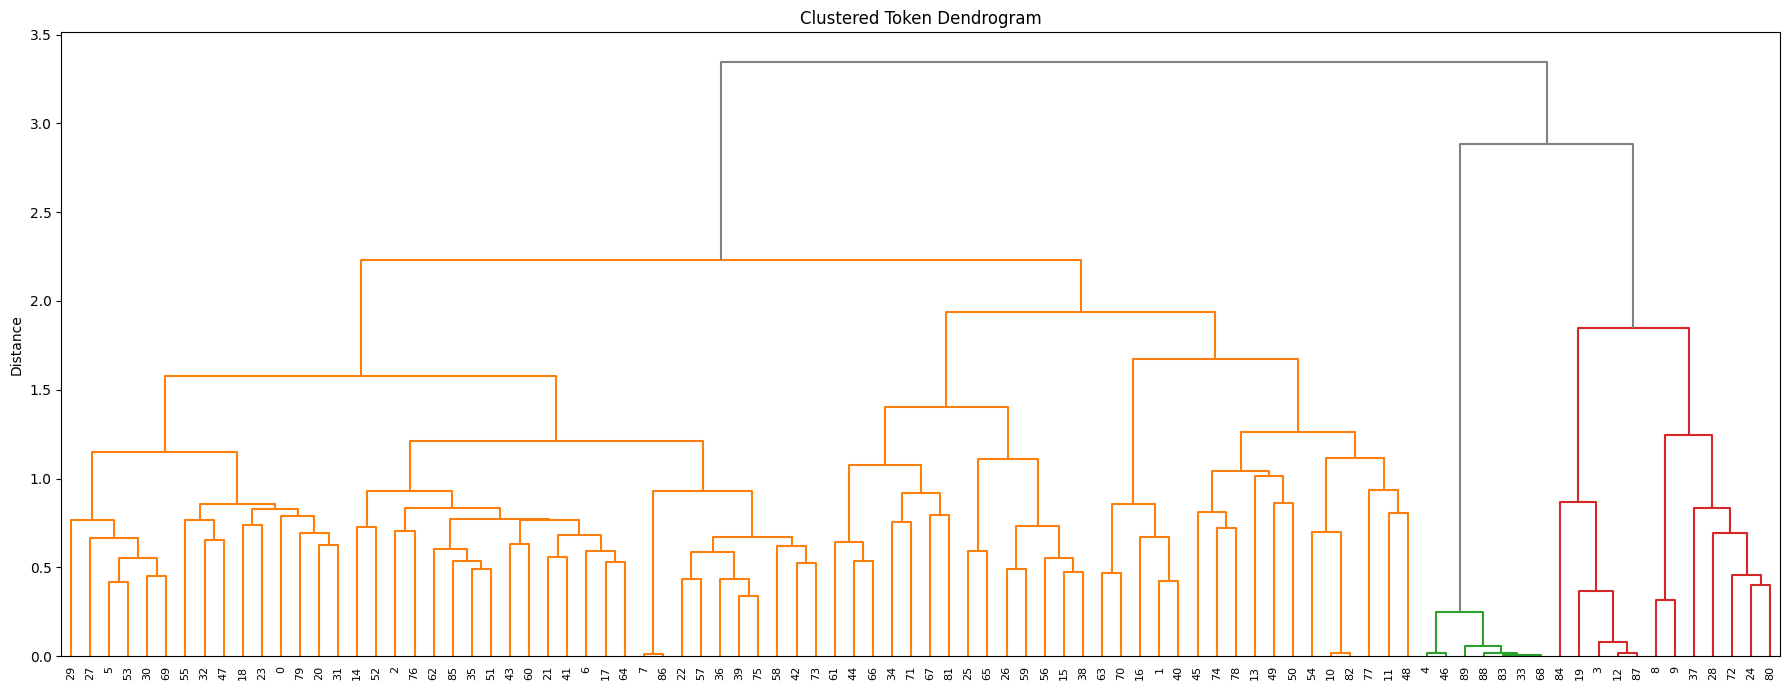

In [28]:
plt.figure(figsize=(18,7))
dn = dendrogram(Z, 
                labels=tokens, 
                color_threshold=None, 
                above_threshold_color='gray', 
                leaf_rotation=90, 
                leaf_font_size=8)
plt.title("Clustered Token Dendrogram")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


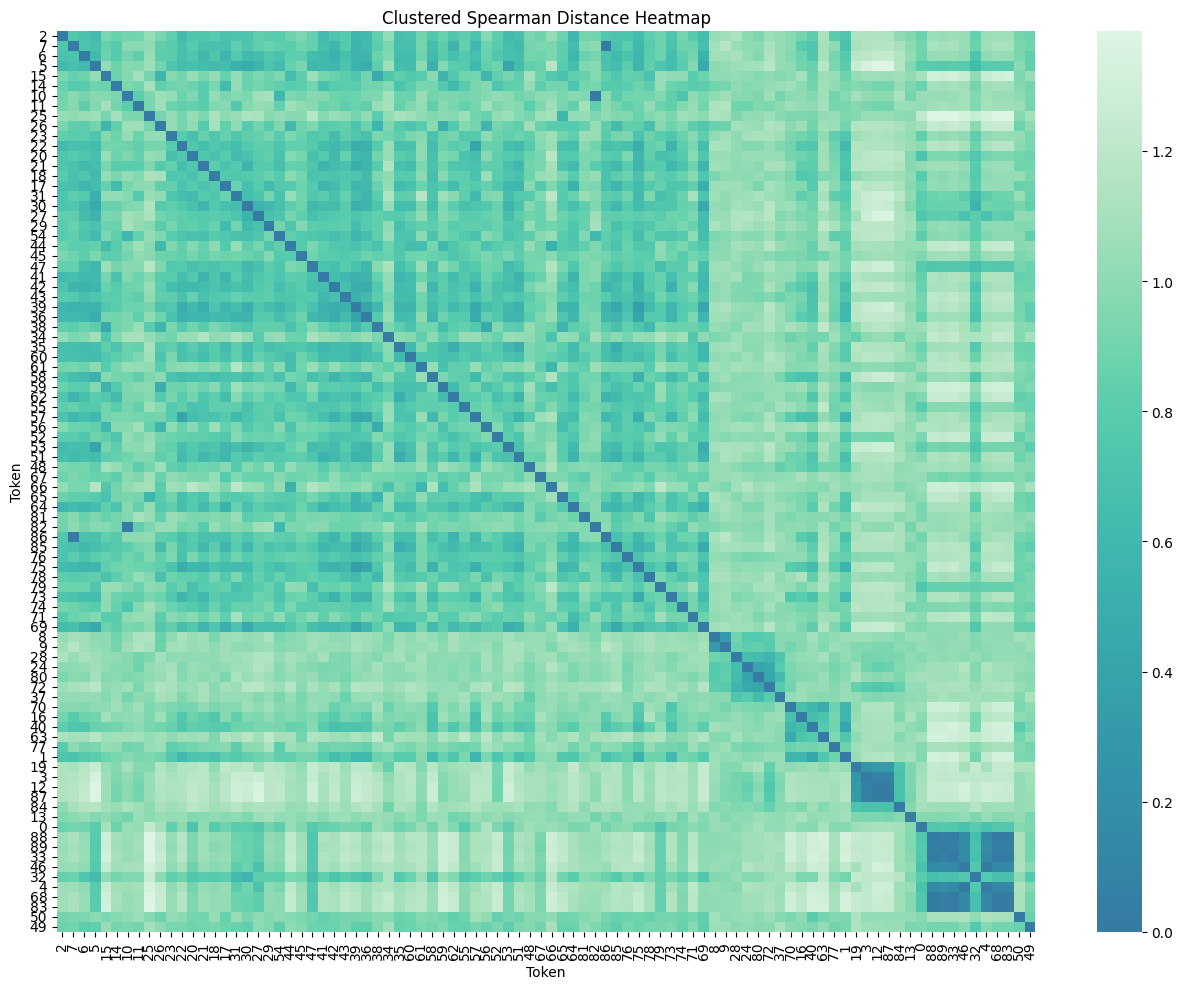

In [29]:
import seaborn as sns
import numpy as np

# Sort tokens by cluster
order = np.argsort(clusters)
sorted_matrix = dist_matrix[order][:, order]
sorted_tokens = np.array(tokens)[order]

plt.figure(figsize=(13,10))
sns.heatmap(sorted_matrix, xticklabels=sorted_tokens, yticklabels=sorted_tokens, cmap="mako", center=0)
plt.title("Clustered Spearman Distance Heatmap")
plt.xlabel("Token")
plt.ylabel("Token")
plt.tight_layout()
plt.show()
